Connect with Drive

In [79]:
from google.colab import drive
drive.mount('/content/my_drive')

Drive already mounted at /content/my_drive; to attempt to forcibly remount, call drive.mount("/content/my_drive", force_remount=True).


Import libraries

In [80]:
import cv2
import numpy as np
import json
import os

Define paths to folders with the images

In [81]:
# Folder with the initial original images and its label json
original_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/Relay/Manquen"
annotations_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/Relay/Manquen"
# Folder to save the intermediate images created with different effects to create the mosaic
output_directory = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/1_Effects/Relay"
# Folder to save the final result, the mosaic in grid form displaying all the effects
final_directory = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics/Relay"

Select label classes

In [82]:
# Specify the classes you want to process
specified_classes = ["CB2p", "CB3p", "Relay"]  # Add or remove classes as desireed

### **EXTRACTION OF THE LABEL (ORIGINAL IMAGE)**

In [84]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Function to save the extracted region
def save_extracted_region(image_path, shape, annotation_data, output_directory, suffix, class_counts):
    # Read the image
    image = cv2.imread(image_path)

    # Get bounding box of the annotation
    points = np.array(shape['points'], np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x_end = min(x + w, image.shape[1])
    y_end = min(y + h, image.shape[0])
    region = image[y:y_end, x:x_end]

    # Create a new blank image with the same size as the region
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)
    blank_image[0:region.shape[0], 0:region.shape[1]] = region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in shape['points']],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Get the index for the current class
    class_index = class_counts[shape['label']]

    # Create new annotation data
    new_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{suffix}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{suffix}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{suffix}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_annotation_data, f)

    # Increment the count for the current class
    class_counts[shape['label']] += 1

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Track the count of each class
        class_counts = {}

        # Process each shape and save the regions for specified classes
        for shape in shapes:
            if shape['label'] in specified_classes:
                if shape['label'] not in class_counts:
                    class_counts[shape['label']] = 0
                save_extracted_region(original_image_path, shape, annotation_data, output_directory, 'extracted', class_counts)

print("Extraction and saving completed.")


Extraction and saving completed.


### **CONTRAST**

In [68]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define a list of contrast factors
contrast_factors = [0.5, 1.5]  # You can modify this list with desired contrast factors by adding or deleting values

# Function to apply contrast to image
def apply_contrast(image, factor):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

# Function to save the extracted region with contrast effect
def save_extracted_region_with_contrast(image_path, shape, annotation_data, output_directory, contrast_factor, suffix, element_index):
    # Read original image
    image = cv2.imread(image_path)

    # Get bounding box of the annotation
    points = np.array(shape['points'], np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x_end = min(x + w, image.shape[1])
    y_end = min(y + h, image.shape[0])
    region = image[y:y_end, x:x_end]

    # Apply contrast to the region
    contrasted_region = apply_contrast(region, contrast_factor)

    # Create a new blank image with the same size as the region
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)
    blank_image[0:contrasted_region.shape[0], 0:contrasted_region.shape[1]] = contrasted_region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in shape['points']],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Create new annotation data
    new_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}_{contrast_factor}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the contrasted region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}_{contrast_factor}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}_{contrast_factor}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_annotation_data, f)

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Track the count of each class
        class_counts = {}

        # Process each shape and save the regions with contrast effect for specified classes
        for shape in shapes:
            if shape['label'] in specified_classes:
                if shape['label'] not in class_counts:
                    class_counts[shape['label']] = 0
                element_index = class_counts[shape['label']]
                for contrast_factor in contrast_factors:
                    save_extracted_region_with_contrast(original_image_path, shape, annotation_data, output_directory, contrast_factor, 'contrast', element_index)
                class_counts[shape['label']] += 1

print("Contrast effect applied and images saved.")


Contrast effect applied and images saved.


### **GRAYSCALE**

In [69]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Function to apply grayscale to image
def apply_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to save the extracted region with grayscale effect
def save_extracted_region_with_grayscale(image_path, shape, annotation_data, output_directory, suffix, element_index):
    # Read original image
    image = cv2.imread(image_path)

    # Get bounding box of the annotation
    points = np.array(shape['points'], np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x_end = min(x + w, image.shape[1])
    y_end = min(y + h, image.shape[0])
    region = image[y:y_end, x:x_end]

    # Apply grayscale to the region
    grayscale_region = apply_grayscale(region)

    # Convert grayscale image back to 3 channels
    grayscale_region = cv2.cvtColor(grayscale_region, cv2.COLOR_GRAY2BGR)

    # Create a new blank image with the same size as the region
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)
    blank_image[0:grayscale_region.shape[0], 0:grayscale_region.shape[1]] = grayscale_region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in shape['points']],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Create new annotation data
    new_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the grayscale region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{suffix}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_annotation_data, f)

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Track the count of each class
        class_counts = {}

        # Process each shape and save the regions with grayscale effect for specified classes
        for shape in shapes:
            if shape['label'] in specified_classes:
                if shape['label'] not in class_counts:
                    class_counts[shape['label']] = 0
                element_index = class_counts[shape['label']]
                save_extracted_region_with_grayscale(original_image_path, shape, annotation_data, output_directory, 'grayscale', element_index)
                class_counts[shape['label']] += 1

print("Grayscale effect applied and images saved.")


Grayscale effect applied and images saved.


### **FLIP**

In [70]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the flip types
flip_types = ['horizontal', 'vertical']

# Function to apply flip to image and update points
def apply_flip(image, points, flip_type):
    h, w = image.shape[:2]
    if flip_type == 'horizontal':
        flipped_image = cv2.flip(image, 1)
        flipped_points = [[w - point[0], point[1]] for point in points]
    elif flip_type == 'vertical':
        flipped_image = cv2.flip(image, 0)
        flipped_points = [[point[0], h - point[1]] for point in points]
    return flipped_image, flipped_points

# Function to save the extracted region with flip effect
def save_extracted_region_with_flip(image_path, shapes, annotation_data, output_directory, flip_type):
    # Read original image
    image = cv2.imread(image_path)

    # Apply flip to the entire image and all points
    flipped_image, flipped_shapes = image, []
    for shape in shapes:
        flipped_image, flipped_points = apply_flip(image, shape['points'], flip_type)
        new_shape = {
            'label': shape['label'],
            'points': flipped_points,
            'group_id': shape.get('group_id'),
            'shape_type': shape['shape_type'],
            'flags': shape.get('flags', {})
        }
        flipped_shapes.append(new_shape)

    # Update annotation with flipped shapes
    new_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': flipped_shapes,
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{flip_type}.jpg",
        'imageHeight': flipped_image.shape[0],
        'imageWidth': flipped_image.shape[1]
    }

    # We provisionally create an image with the flip effect and then extract the label (the part that interests us)
    # Save the flipped image
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{flip_type}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, flipped_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{flip_type}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_annotation_data, f, indent=4)

    # Process each shape and save the regions for specified classes
    class_counts = {}
    for shape in flipped_shapes:
        if shape['label'] in specified_classes:
            if shape['label'] not in class_counts:
                class_counts[shape['label']] = 0
            element_index = class_counts[shape['label']]

            # Get bounding box of the annotation
            points = np.array(shape['points'], np.int32)
            x, y, w, h = cv2.boundingRect(points)

            # Ensure the region coordinates are within image boundaries
            x_end = min(x + w, flipped_image.shape[1])
            y_end = min(y + h, flipped_image.shape[0])
            region = flipped_image[y:y_end, x:x_end]

            # Create a new blank image with the same size as the region
            blank_image = np.zeros((h, w, 3), dtype=np.uint8)
            blank_image[0:region.shape[0], 0:region.shape[1]] = region

            # Adjust the coordinates for the new position
            new_shape = {
                'label': shape['label'],
                'points': [[point[0] - x, point[1] - y] for point in shape['points']],
                'group_id': shape.get('group_id'),
                'shape_type': shape['shape_type'],
                'flags': shape.get('flags', {})
            }

            # Create new annotation data for the region
            new_annotation_data = {
                'version': annotation_data['version'],
                'flags': annotation_data['flags'],
                'shapes': [new_shape],
                'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{flip_type}.jpg",
                'imageHeight': blank_image.shape[0],
                'imageWidth': blank_image.shape[1]
            }

            # Save the blank image with the region
            new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{flip_type}.jpg"
            new_image_path = os.path.join(output_directory, new_image_name)
            cv2.imwrite(new_image_path, blank_image)

            # Save the new annotation
            new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{element_index}_{flip_type}.json"
            new_annotation_path = os.path.join(output_directory, new_annotation_name)
            with open(new_annotation_path, 'w') as f:
                json.dump(new_annotation_data, f, indent=4)

            class_counts[shape['label']] += 1

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Apply flip effects and save
        for flip_type in flip_types:
            save_extracted_region_with_flip(original_image_path, shapes, annotation_data, output_directory, flip_type)

print("Flip effects applied and images saved.")

Flip effects applied and images saved.


### **ROTATION**

In [71]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the rotation angles (in degrees)
rotation_angles = [20, -20]  # Positive and negative rotations

# Function to apply rotation to image and update points
def apply_rotation(image, points, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))

    # Rotate points
    rotated_points = []
    for point in points:
        new_point = np.dot(M, np.array([point[0], point[1], 1]))
        rotated_points.append(new_point.tolist())

    return rotated_image, rotated_points

# Function to save the extracted region with rotation effect
def save_extracted_region_with_rotation(image_path, shape, annotation_data, output_directory, angle, class_counts):
    # Read original image
    image = cv2.imread(image_path)

    # Apply rotation to the entire image and all points
    rotated_image, rotated_points = apply_rotation(image, shape['points'], angle)

    # Get bounding box of the annotation
    points = np.array(rotated_points, np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x = max(x, 0)
    y = max(y, 0)
    x_end = min(x + w, rotated_image.shape[1])
    y_end = min(y + h, rotated_image.shape[0])
    region = rotated_image[y:y_end, x:x_end]

    # Create a new blank image with the same size as the region
    blank_image = np.zeros((y_end - y, x_end - x, 3), dtype=np.uint8)
    blank_image[0:region.shape[0], 0:region.shape[1]] = region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in rotated_points],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Create new annotation data for the region
    class_index = class_counts[shape['label']]
    new_region_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{angle}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{angle}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{angle}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_region_annotation_data, f, indent=4)

    class_counts[shape['label']] += 1

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Apply rotation effects and save
        for angle in rotation_angles:
            # Track the count of each class for unique naming
            class_counts = {label: 0 for label in specified_classes}
            for shape in shapes:
                if shape['label'] in specified_classes:
                    save_extracted_region_with_rotation(original_image_path, shape, annotation_data, output_directory, angle, class_counts)

print("Rotation effects applied and images saved.")

Rotation effects applied and images saved.


### **SCALE**

In [72]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the scale factors (as many as we want)
scale_factors = [0.8, 1.2]  # Example scale factors (0.5 means scaling down by 50%, 1.5 means scaling up by 50%)

# Function to apply scale to points
def scale_points(points, scale_factor):
    return [[point[0] * scale_factor, point[1] * scale_factor] for point in points]

# Function to apply scale to image and update points
def apply_scale(image, points, scale_factor):
    (h, w) = image.shape[:2]
    scaled_image = cv2.resize(image, (int(w * scale_factor), int(h * scale_factor)))
    scaled_points = scale_points(points, scale_factor)
    return scaled_image, scaled_points

# Function to save the extracted region with scale effect
def save_extracted_region_with_scale(image_path, shape, annotation_data, output_directory, scale_factor, class_counts):
    # Read original image
    image = cv2.imread(image_path)

    # Apply scale to the entire image and all points
    scaled_image, scaled_points = apply_scale(image, shape['points'], scale_factor)

    # Get bounding box of the annotation
    points = np.array(scaled_points, np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x_end = min(x + w, scaled_image.shape[1])
    y_end = min(y + h, scaled_image.shape[0])
    region = scaled_image[y:y_end, x:x_end]

    # Create a new blank image with the same size as the region
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)
    blank_image[0:region.shape[0], 0:region.shape[1]] = region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in scaled_points],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Create new annotation data for the region
    class_index = class_counts[shape['label']]
    new_region_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}__scale_{scale_factor}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_scale_{scale_factor}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_scale_{scale_factor}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_region_annotation_data, f, indent=4)

    class_counts[shape['label']] += 1

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Apply scale effects and save
        for scale_factor in scale_factors:
            # Track the count of each class for unique naming
            class_counts = {label: 0 for label in specified_classes}
            for shape in shapes:
                if shape['label'] in specified_classes:
                    save_extracted_region_with_scale(original_image_path, shape, annotation_data, output_directory, scale_factor, class_counts)

print("Scale effects applied and images saved.")

Scale effects applied and images saved.


### **SHEAR**

In [73]:
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define the shear factors
shear_factors = [0.2]  # Example shear factors

# Function to apply shear to points
def shear_points(points, shear_factor, direction='x'):
    if direction == 'x':
        return [[point[0] + shear_factor * point[1], point[1]] for point in points]
    elif direction == 'y':
        return [[point[0], point[1] + shear_factor * point[0]] for point in points]

# Function to apply shear to image and update points
def apply_shear(image, points, shear_factor, direction='x'):
    (h, w) = image.shape[:2]
    if direction == 'x':
        M = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    elif direction == 'y':
        M = np.float32([[1, 0, 0], [shear_factor, 1, 0]])
    sheared_image = cv2.warpAffine(image, M, (w, h))
    sheared_points = shear_points(points, shear_factor, direction)
    return sheared_image, sheared_points

# Function to save the extracted region with shear effect
def save_extracted_region_with_shear(image_path, shape, annotation_data, output_directory, shear_factor, direction, class_counts):
    # Read original image
    image = cv2.imread(image_path)

    # Apply shear to the entire image and all points
    sheared_image, sheared_points = apply_shear(image, shape['points'], shear_factor, direction)

    # Get bounding box of the annotation
    points = np.array(sheared_points, np.int32)
    x, y, w, h = cv2.boundingRect(points)

    # Ensure the region coordinates are within image boundaries
    x = max(x, 0)
    y = max(y, 0)
    x_end = min(x + w, sheared_image.shape[1])
    y_end = min(y + h, sheared_image.shape[0])
    region = sheared_image[y:y_end, x:x_end]

    # Create a new blank image with the same size as the region
    region_height, region_width = region.shape[:2]
    blank_image = np.zeros((region_height, region_width, 3), dtype=np.uint8)
    blank_image[0:region_height, 0:region_width] = region

    # Adjust the coordinates for the new position
    new_shape = {
        'label': shape['label'],
        'points': [[point[0] - x, point[1] - y] for point in sheared_points],
        'group_id': shape.get('group_id'),
        'shape_type': shape['shape_type'],
        'flags': shape.get('flags', {})
    }

    # Create new annotation data for the region
    class_index = class_counts[shape['label']]
    new_region_annotation_data = {
        'version': annotation_data['version'],
        'flags': annotation_data['flags'],
        'shapes': [new_shape],
        'imagePath': f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{direction}_shear_{shear_factor}.jpg",
        'imageHeight': blank_image.shape[0],
        'imageWidth': blank_image.shape[1]
    }

    # Save the blank image with the region
    new_image_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{direction}_shear_{shear_factor}.jpg"
    new_image_path = os.path.join(output_directory, new_image_name)
    cv2.imwrite(new_image_path, blank_image)

    # Save the new annotation
    new_annotation_name = f"{os.path.basename(image_path).split('.')[0]}_{shape['label']}_{class_index}_{direction}_shear_{shear_factor}.json"
    new_annotation_path = os.path.join(output_directory, new_annotation_name)
    with open(new_annotation_path, 'w') as f:
        json.dump(new_region_annotation_data, f, indent=4)

    class_counts[shape['label']] += 1

# Process each image and its corresponding annotation
for filename in os.listdir(original_images_folder):
    if filename.endswith(".jpg"):
        # Read original image
        original_image_path = os.path.join(original_images_folder, filename)

        # Load original annotation
        annotation_filename = filename.replace(".jpg", ".json")
        original_annotation_path = os.path.join(annotations_folder, annotation_filename)
        with open(original_annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Extract shapes from annotation
        shapes = annotation_data['shapes']

        # Apply shear effects and save
        for shear_factor in shear_factors:
            for direction in ['x', 'y']:
                # Track the count of each class for unique naming
                class_counts = {label: 0 for label in specified_classes}
                for shape in shapes:
                    if shape['label'] in specified_classes:
                        save_extracted_region_with_shear(original_image_path, shape, annotation_data, output_directory, shear_factor, direction, class_counts)

print("Shear effects applied and images saved.")

Shear effects applied and images saved.


### **GRID MOSAIC** GENERATION

In [74]:
import cv2
import numpy as np
import json
import os

def merge_images(original_image, label_images, label_annotations, margin=50):
    # Get the dimensions of the original image
    original_height, original_width, _ = original_image.shape

    # Count the number of label images
    num_images = len(label_images)

    # Calculate the number of rows and columns for the grid layout
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    # Calculate the maximum dimensions of the label images
    max_label_height = max([img.shape[0] for img in label_images])
    max_label_width = max([img.shape[1] for img in label_images])

    # Calculate the size of each cell in the grid
    cell_height = (original_height - (num_rows + 1) * margin) // num_rows
    cell_width = (original_width - (num_cols + 1) * margin) // num_cols

    # If the maximum label dimensions are larger than the cell size, adjust the cell size
    cell_height = max(cell_height, max_label_height)
    cell_width = max(cell_width, max_label_width)

    # Calculate the required canvas size
    required_height = num_rows * (cell_height + margin) + margin
    required_width = num_cols * (cell_width + margin) + margin

    # Initialize the new image with the required size
    new_image = np.zeros((required_height, required_width, 3), dtype=np.uint8)

    # Initialize variables for placing images
    current_row = 0
    current_col = 0

    # List to store updated annotations
    updated_shapes = []

    for i in range(num_images):
        # Get the label image and its annotation
        label_image = label_images[i]
        label_annotation = label_annotations[i]

        # Calculate the position to place the label image with margin
        x_offset = (current_col + 1) * margin + current_col * cell_width
        y_offset = (current_row + 1) * margin + current_row * cell_height

        # Place the label image in the new image
        new_image[y_offset:y_offset+label_image.shape[0], x_offset:x_offset+label_image.shape[1]] = label_image

        # Adjust the coordinates of the label annotation
        for shape in label_annotation['shapes']:
            new_points = []
            for point in shape['points']:
                new_points.append([point[0] + x_offset, point[1] + y_offset])
            shape['points'] = new_points
            updated_shapes.append(shape)

        # Move to the next column or row
        current_col += 1
        if current_col >= num_cols:
            current_col = 0
            current_row += 1

    # Create the final annotation dictionary
    merged_annotation = {
        "version": "5.4.1",
        "flags": {},
        "shapes": updated_shapes,
        "imagePath": "merged_image.jpg",
        "imageData": None,
        "imageHeight": required_height,
        "imageWidth": required_width
    }

    return new_image, merged_annotation

def process_images(original_images_folder, input_images_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for original_filename in os.listdir(original_images_folder):
        if original_filename.endswith(".jpg"):
            original_image_path = os.path.join(original_images_folder, original_filename)
            original_image = cv2.imread(original_image_path)

            if original_image is None:
                print(f"Error: Could not read the original image: {original_image_path}")
                continue

            print(f"Processing original image: {original_image_path}")
            base_name = os.path.splitext(original_filename)[0]

            label_groups = {}

            for filename in os.listdir(input_images_folder):
                if filename.startswith(base_name) and filename.endswith(".jpg"):
                    parts = filename.split("_")
                    if len(parts) > 3:  # Ensure there are enough parts to avoid IndexError
                        label = parts[2]  # Use the third part of the name for grouping
                        class_index = parts[3]  # Use the fourth part of the name for grouping

                        key = f"{label}_{class_index}"
                        if key not in label_groups:
                            label_groups[key] = {"images": [], "annotations": []}

                        image_path = os.path.join(input_images_folder, filename)
                        label_image = cv2.imread(image_path)

                        if label_image is None:
                            print(f"Error: Could not read the label image: {image_path}")
                            continue

                        label_groups[key]["images"].append(label_image)

                        annotation_filename = os.path.splitext(filename)[0] + '.json'
                        annotation_path = os.path.join(input_images_folder, annotation_filename)
                        try:
                            with open(annotation_path, 'r') as f:
                                label_groups[key]["annotations"].append(json.load(f))
                        except FileNotFoundError:
                            print(f"Error: Annotation file not found: {annotation_path}")
                            continue

            for key, data in label_groups.items():
                if len(data["images"]) > 0:
                    merged_image, merged_annotation = merge_images(original_image, data["images"], data["annotations"], margin=50)
                    output_image_name = f"{base_name}_{key}_mosaic.jpg"
                    output_annotation_name = f"{base_name}_{key}_mosaic.json"

                    merged_image_path = os.path.join(output_folder, output_image_name)
                    cv2.imwrite(merged_image_path, merged_image)
                    print(f"Saved merged image: {merged_image_path}")

                    merged_annotation_path = os.path.join(output_folder, output_annotation_name)
                    with open(merged_annotation_path, 'w') as f:
                        json.dump(merged_annotation, f)
                    print(f"Saved merged annotation: {merged_annotation_path}")

    print("Merged images and annotations saved successfully.")

# Paths to the directories
original_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/CB2p"
input_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/1_Effects/CB2p"
final_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics"

# Process the images
process_images(original_images_folder, input_images_folder, final_folder)


Processing original image: /content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/CB2p/CB2p_053.jpg


KeyboardInterrupt: 

### GRID MOSAIC CORREGIT

In [75]:
def merge_images(original_image, label_images, label_annotations, output_image_name, margin=50):
    # Get the dimensions of the original image
    original_height, original_width, _ = original_image.shape

    # Count the number of label images
    num_images = len(label_images)

    # Calculate the number of rows and columns for the grid layout
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    # Calculate the maximum dimensions of the label images
    max_label_height = max([img.shape[0] for img in label_images])
    max_label_width = max([img.shape[1] for img in label_images])

    # Calculate the size of each cell in the grid
    cell_height = max_label_height
    cell_width = max_label_width

    # Calculate the required canvas size
    required_height = num_rows * (cell_height + margin) + margin
    required_width = num_cols * (cell_width + margin) + margin

    # Initialize the new image with the required size
    new_image = np.zeros((required_height, required_width, 3), dtype=np.uint8)

    # Initialize variables for placing images
    current_row = 0
    current_col = 0

    # List to store updated annotations
    updated_shapes = []

    for i in range(num_images):
        # Get the label image and its annotation
        label_image = label_images[i]
        label_annotation = label_annotations[i]

        # Calculate the position to place the label image with margin
        x_offset = (current_col + 1) * margin + current_col * cell_width
        y_offset = (current_row + 1) * margin + current_row * cell_height

        # Ensure the image fits within the new image dimensions
        if y_offset + label_image.shape[0] > new_image.shape[0]:
            new_image = cv2.copyMakeBorder(new_image, 0, y_offset + label_image.shape[0] - new_image.shape[0], 0, 0, cv2.BORDER_CONSTANT)
        if x_offset + label_image.shape[1] > new_image.shape[1]:
            new_image = cv2.copyMakeBorder(new_image, 0, 0, 0, x_offset + label_image.shape[1] - new_image.shape[1], cv2.BORDER_CONSTANT)

        # Place the label image in the new image
        new_image[y_offset:y_offset+label_image.shape[0], x_offset:x_offset+label_image.shape[1]] = label_image

        # Adjust the coordinates of the label annotation
        for shape in label_annotation['shapes']:
            new_points = []
            for point in shape['points']:
                new_points.append([point[0] + x_offset, point[1] + y_offset])
            shape['points'] = new_points
            updated_shapes.append(shape)

        # Move to the next column or row
        current_col += 1
        if current_col >= num_cols:
            current_col = 0
            current_row += 1

    # Create the final annotation dictionary
    merged_annotation = {
        "version": "5.4.1",
        "flags": {},
        "shapes": updated_shapes,
        "imagePath": output_image_name,
        "imageData": None,
        "imageHeight": new_image.shape[0],
        "imageWidth": new_image.shape[1]
    }

    return new_image, merged_annotation

def process_images(original_images_folder, input_images_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for original_filename in os.listdir(original_images_folder):
        if original_filename.endswith(".jpg"):
            original_image_path = os.path.join(original_images_folder, original_filename)
            original_image = cv2.imread(original_image_path)

            if original_image is None:
                print(f"Error: Could not read the original image: {original_image_path}")
                continue

            print(f"Processing original image: {original_image_path}")
            base_name = os.path.splitext(original_filename)[0]

            label_groups = {}

            for filename in os.listdir(input_images_folder):
                if filename.startswith(base_name) and filename.endswith(".jpg"):
                    parts = filename.split("_")
                    if len(parts) > 3:  # Ensure there are enough parts to avoid IndexError
                        label = parts[2]  # Use the third part of the name for grouping
                        class_index = parts[3]  # Use the fourth part of the name for grouping

                        key = f"{label}_{class_index}"
                        if key not in label_groups:
                            label_groups[key] = {"images": [], "annotations": []}

                        image_path = os.path.join(input_images_folder, filename)
                        label_image = cv2.imread(image_path)

                        if label_image is None:
                            print(f"Error: Could not read the label image: {image_path}")
                            continue

                        label_groups[key]["images"].append(label_image)

                        annotation_filename = os.path.splitext(filename)[0] + '.json'
                        annotation_path = os.path.join(input_images_folder, annotation_filename)
                        try:
                            with open(annotation_path, 'r') as f:
                                label_groups[key]["annotations"].append(json.load(f))
                        except FileNotFoundError:
                            print(f"Error: Annotation file not found: {annotation_path}")
                            continue

            for key, data in label_groups.items():
                if len(data["images"]) > 0:
                    output_image_name = f"{base_name}_{key}_mosaic.jpg"
                    merged_image, merged_annotation = merge_images(original_image, data["images"], data["annotations"], output_image_name, margin=50)

                    output_annotation_name = f"{base_name}_{key}_mosaic.json"

                    merged_image_path = os.path.join(output_folder, output_image_name)
                    cv2.imwrite(merged_image_path, merged_image)
                    print(f"Saved merged image: {merged_image_path}")

                    merged_annotation_path = os.path.join(output_folder, output_annotation_name)
                    with open(merged_annotation_path, 'w') as f:
                        json.dump(merged_annotation, f)
                    print(f"Saved merged annotation: {merged_annotation_path}")

    print("Merged images and annotations saved successfully.")

# Paths to the directories
original_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/Relay/Manquen"
input_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/1_Effects/Relay"
final_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics/Relay"

# Process the images
process_images(original_images_folder, input_images_folder, final_folder)

Processing original image: /content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/0_Elements/Relay/Manquen/relay_061.jpg
Saved merged image: /content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics/Relay/relay_061_Relay_0_mosaic.jpg
Saved merged annotation: /content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics/Relay/relay_061_Relay_0_mosaic.json
Merged images and annotations saved successfully.


### **VISUALIZATION** OF THE ORIGINAL IMAGE NEXT TO THE GRID MOSAIC

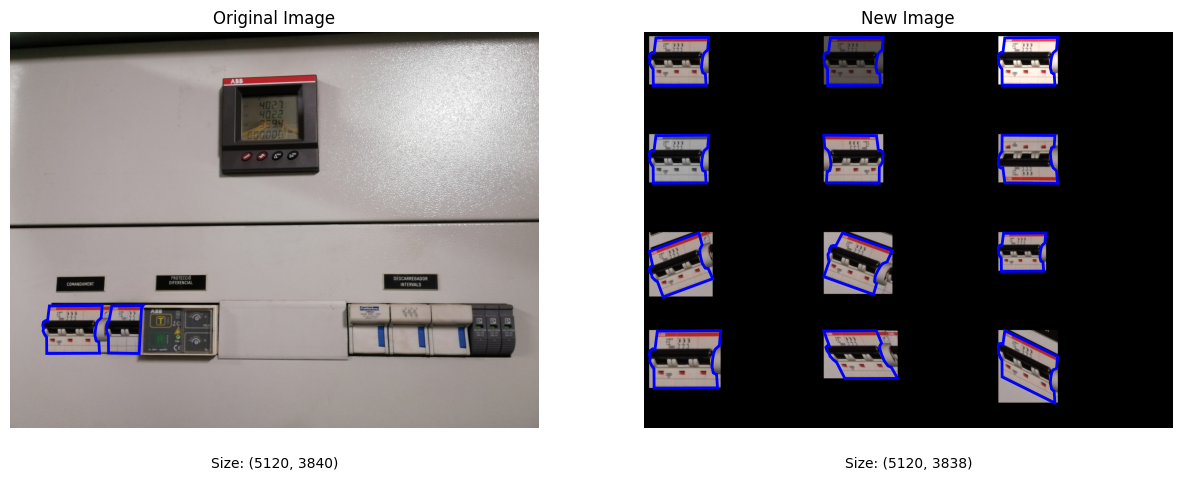

In [ ]:
import json
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon, Rectangle

# Paths to the original and modified images and annotations
original_image_path = "/content/my_drive/MyDrive/00_TFM/08_DataAugmentation/0_Original/image_044.jpg"
original_annotation_path = "/content/my_drive/MyDrive/00_TFM/08_DataAugmentation/0_Original/image_044.json"
modified_image_path = "/content/my_drive/MyDrive/00_TFM/08_DataAugmentation/2_Mosaic/image_044_CB3p_0_mosaic.jpg"
modified_annotation_path = "/content/my_drive/MyDrive/00_TFM/08_DataAugmentation/2_Mosaic/image_044_CB3p_0_mosaic.json"

# Load images
original_image = Image.open(original_image_path)
modified_image = Image.open(modified_image_path)

# Load JSON annotations
with open(original_annotation_path, 'r') as f:
    original_annotations = json.load(f)

with open(modified_annotation_path, 'r') as f:
    modified_annotations = json.load(f)

# Create figure and axis for the original and modified images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Original image with annotations
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

for shape in original_annotations['shapes']:
    if shape['shape_type'] == 'polygon':
        points = shape['points']
        polygon = Polygon(points, closed=True, edgecolor='b', linewidth=2, facecolor='none')
        axs[0].add_patch(polygon)
    elif shape['shape_type'] == 'rectangle':
        points = shape['points']
        xmin, ymin = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
        width, height = abs(points[1][0] - points[0][0]), abs(points[1][1] - points[0][1])
        rectangle = Rectangle((xmin, ymin), width, height, edgecolor='r', linewidth=2, fill=False)
        axs[0].add_patch(rectangle)

axs[0].axis('off')
axs[0].annotate(f"Size: {original_image.size}", xy=(0.5, -0.1), xycoords="axes fraction", ha="center")

# Modified image with annotations
axs[1].imshow(modified_image)
axs[1].set_title('New Image')

for shape in modified_annotations['shapes']:
    if shape['shape_type'] == 'polygon':
        points = shape['points']
        polygon = Polygon(points, closed=True, edgecolor='b', linewidth=2, facecolor='none')
        axs[1].add_patch(polygon)
    elif shape['shape_type'] == 'rectangle':
        points = shape['points']
        xmin, ymin = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
        width, height = abs(points[1][0] - points[0][0]), abs(points[1][1] - points[0][1])
        rectangle = Rectangle((xmin, ymin), width, height, edgecolor='b', linewidth=2, fill=False)
        axs[1].add_patch(rectangle)

axs[1].axis('off')
axs[1].annotate(f"Size: {modified_image.size}", xy=(0.5, -0.1), xycoords="axes fraction", ha="center")

plt.show()


### **VISUALIZATION** OF ALL MOSAIC IMAGES ON A DIRECTORY

In [76]:
# Path to the directory
output_images_folder = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/2_Mosaics/Relay"

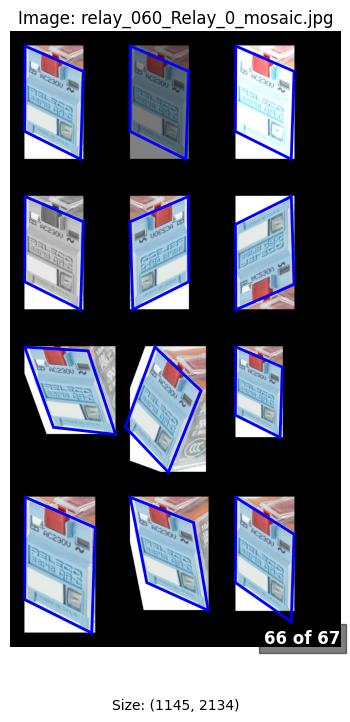

In [77]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image
import os
from ipywidgets import widgets, HBox, VBox, Label
from IPython.display import display, clear_output

# Get the list of image files and corresponding JSON files in the output directory
image_files = sorted([f for f in os.listdir(output_images_folder) if f.endswith('.jpg')])
annotation_files = sorted([f for f in os.listdir(output_images_folder) if f.endswith('.json')])

# Check that the number of image files matches the number of annotation files
assert len(image_files) == len(annotation_files), "Mismatch between number of images and annotation files"

# Initialize the index
current_index = 0

# Function to load and display an image with its annotations
def display_image(index):
    image_path = os.path.join(output_images_folder, image_files[index])
    annotation_path = os.path.join(output_images_folder, annotation_files[index])

    # Load image and annotations
    image = Image.open(image_path)
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f'Image: {image_files[index]}')

    # Add annotations
    for shape in annotations['shapes']:
        if shape['shape_type'] == 'polygon':
            points = shape['points']
            polygon = Polygon(points, closed=True, edgecolor='b', linewidth=2, facecolor='none')
            ax.add_patch(polygon)
        elif shape['shape_type'] == 'rectangle':
            points = shape['points']
            xmin, ymin = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
            width, height = abs(points[1][0] - points[0][0]), abs(points[1][1] - points[0][1])
            rectangle = Rectangle((xmin, ymin), width, height, edgecolor='b', linewidth=2, fill=False)
            ax.add_patch(rectangle)

    ax.axis('off')
    ax.annotate(f"Size: {image.size}", xy=(0.5, -0.1), xycoords="axes fraction", ha="center")

    # Display the image number in the bottom right corner
    ax.annotate(f"{index + 1} of {len(image_files)}", xy=(1, 0), xycoords="axes fraction",
                ha="right", va="bottom", fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', alpha=0.5))
    plt.show()

# Function to update the displayed image
def update_display(button):
    global current_index
    direction = button.description
    if direction == 'Next':
        current_index = (current_index + 1) % len(image_files)
    elif direction == 'Previous':
        current_index = (current_index - 1) % len(image_files)

    # Clear current output and display new image
    clear_output(wait=True)
    display_image(current_index)
    display(nav_buttons)

# Create navigation buttons
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

# Assign update function to button click events
prev_button.on_click(update_display)
next_button.on_click(update_display)

# Create horizontal box to hold the buttons
nav_buttons = HBox([prev_button, next_button])

# Display the first image and navigation buttons
display_image(current_index)
display(nav_buttons)

### **DELETE** INTERMEDIATE IMAGES

In [78]:
# Define the folder to clear
folder_to_clear = "/content/my_drive/MyDrive/00_TFM/07_NovesImatgesCataleg/1_Effects/Relay"

# Clear the folder
for filename in os.listdir(folder_to_clear):
    file_path = os.path.join(folder_to_clear, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or link
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove the folder and all its contents
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("Folder cleared successfully.")

Folder cleared successfully.
